In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import Ridge 
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score


In [2]:
# 设置字体为 SimHei（黑体），或者其他支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置字体
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

In [3]:
# 获取当前文件所在目录的父目录
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
parent_parent_dir = os.path.dirname(parent_dir)

if parent_parent_dir not in sys.path:
    sys.path.append(parent_parent_dir)


from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance,plot_predictions


In [4]:
sheet = pd.read_excel('data_input/纯碱开工率.xlsx', sheet_name='Sheet1').rename(columns={'DataTime': 'Date'})
sheet = sheet.set_index('Date')
last_day = sheet['纯碱开工率（周度）noseasonal/F 0.1'].last_valid_index()

future_data_30days = sheet[sheet.index > last_day]
# 生成周五数据,6周的数据
target_days = pd.date_range(start=last_day + pd.DateOffset(1), periods=6, freq='W-FRI')
target_end = target_days[-1]
new_index = pd.date_range(start=last_day + pd.DateOffset(1), end=target_end, freq='W-FRI')
sheet = sheet.reindex(sheet.index.union(new_index))
sheet = sheet[sheet.index <= target_end]

sheet.tail() 

,纯碱开工率（周度）noseasonal/F 0.1,纯碱行业利润/周频,纯碱企业库存8周环差,纯碱开工率（周度）Seasonal/F0.1(预测),纯碱开工率（周度）,纯碱行业利润/周频拟合残差/纯碱开工率（周度）noseasonal/F 0.1
2025-11-07,NaN,NaN,NaN,-8.9839,NaN,NaN
2025-11-14,NaN,NaN,NaN,-8.8713,NaN,NaN
2025-11-21,NaN,NaN,NaN,-8.3561,NaN,NaN
2025-11-28,NaN,NaN,NaN,-7.7247,NaN,NaN
2025-12-05,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
sheet.columns

Index(['纯碱开工率（周度）noseasonal/F 0.1', '纯碱行业利润/周频', '纯碱企业库存8周环差',
       '纯碱开工率（周度）Seasonal/F0.1(预测)', '纯碱开工率（周度）',
       '纯碱行业利润/周频拟合残差/纯碱开工率（周度）noseasonal/F 0.1'],
      dtype='object')

In [6]:


################################# 处理缺失值 #################################
fill_methods = {
'纯碱行业利润/周频' :'interpolate', 
'纯碱企业库存8周环差' :'interpolate',
'纯碱开工率（周度）Seasonal/F0.1(预测)' :'interpolate'
} 
sheet= fill_missing_values(sheet, fill_methods, return_only_filled=False)
# sheet.loc[:last_day, '纯碱开工率（周度）noseasonal/F 0.1'] = sheet.loc[:last_day, '纯碱开工率（周度）noseasonal/F 0.1'].interpolate(method='linear')

#################################  因子处理  #################################

sheet['纯碱行业利润/周频_提前5周'] = sheet['纯碱行业利润/周频'].shift(6)
sheet['纯碱企业库存8周环差_提前8周'] = sheet['纯碱企业库存8周环差'].shift(8)
sheet['纯碱行业利润/周频拟合残差/纯碱开工率（周度）noseasonal/F 0.1_提前9周'] = sheet['纯碱行业利润/周频拟合残差/纯碱开工率（周度）noseasonal/F 0.1'].shift(9)

sheet['纯碱企业库存8周环差_提前8周_逆序'] = reverse_column(sheet, '纯碱企业库存8周环差_提前8周')


sheet['纯碱企业库存8周环差_提前8周_逆序_分类'] = pd.qcut(sheet['纯碱企业库存8周环差_提前8周_逆序'], q=8, labels=range(8))
dummy_vars = pd.get_dummies(sheet['纯碱企业库存8周环差_提前8周_逆序_分类'], prefix='纯碱企业库存8周环差_提前8周_逆序_分类', dtype=float)
sheet = pd.concat([sheet, dummy_vars], axis=1)

################################# 数据筛选  #################################

sheet_daily = sheet.reset_index().rename(columns={'index': 'Date'})
sheet_daily['Date'] = pd.to_datetime(sheet_daily['Date'])

sheet_daily = sheet_daily[sheet_daily['Date'] >= pd.Timestamp('2023-01-01')]

sheet_daily = sheet_daily.reset_index(drop=True)
sheet_daily = sheet_daily[
    (sheet_daily['Date'] > last_day) | 
    (sheet_daily['纯碱开工率（周度）noseasonal/F 0.1'].notna())
]

################################# 数据 读取-处理 结束 #################################

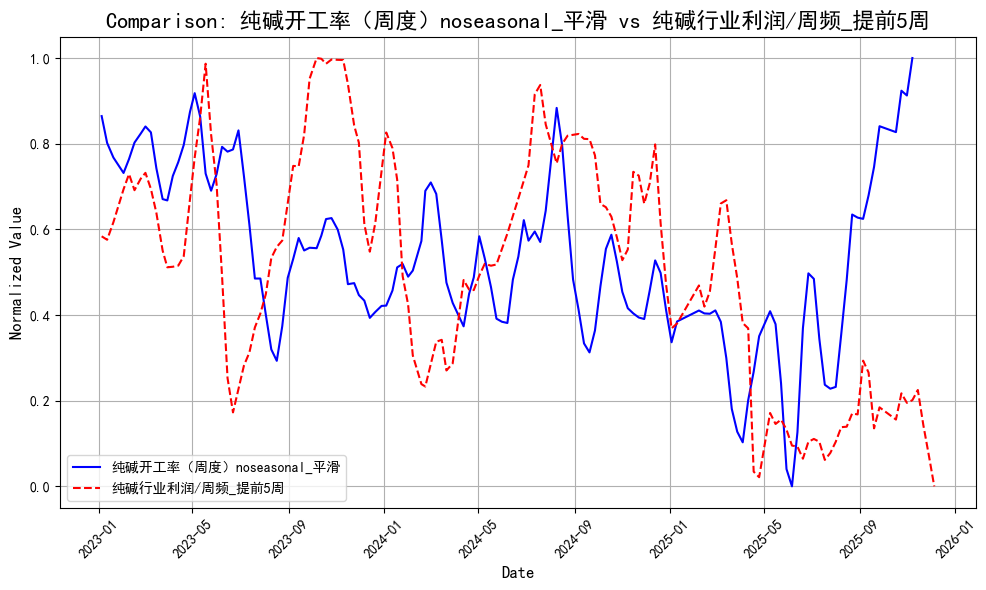

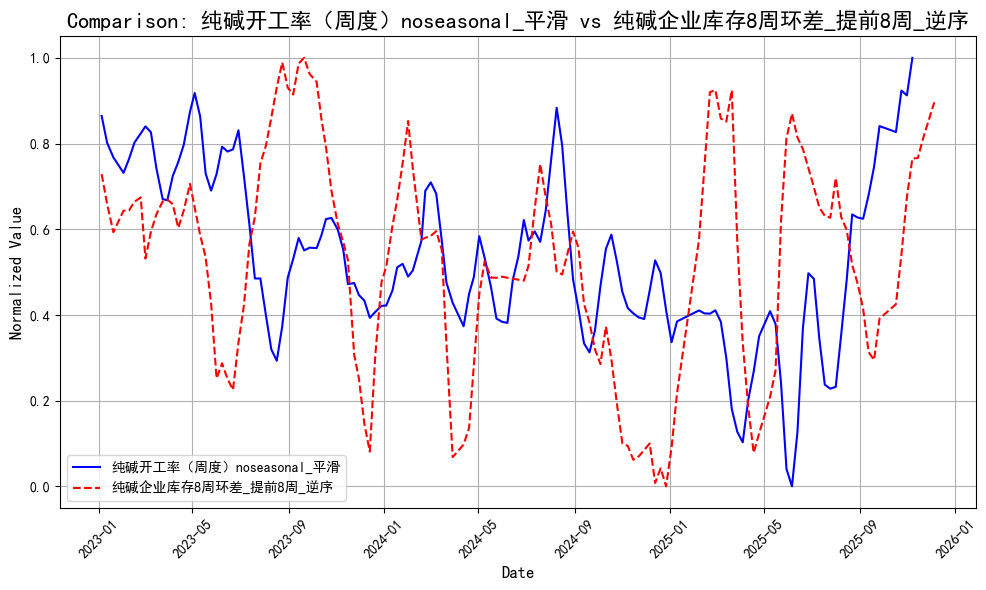

列 '纯碱行业利润/周频_提前5周_平滑' 不存在于 DataFrame 中。
列 '纯碱企业库存8周环差_提前8周_逆序_平滑' 不存在于 DataFrame 中。


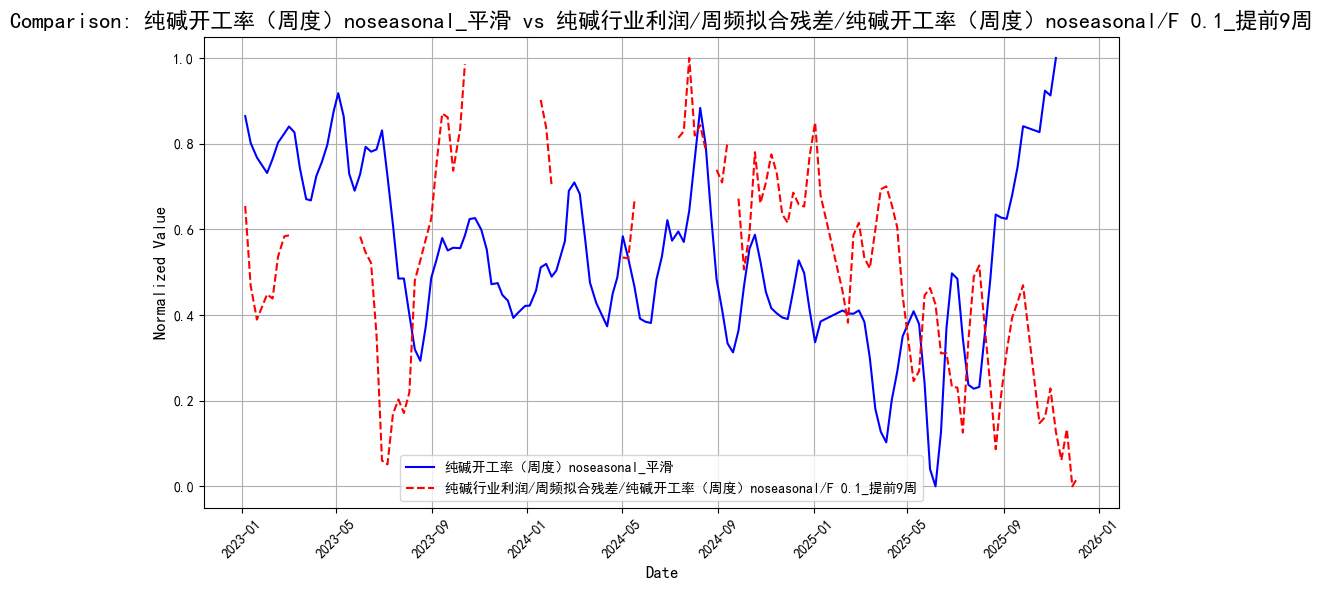

In [7]:

sheet_daily['纯碱开工率（周度）noseasonal_平滑'] = sheet_daily['纯碱开工率（周度）noseasonal/F 0.1'].rolling(window=3, min_periods=1).mean()
'''
sheet_daily['纯碱行业利润/周频_提前5周_平滑'] = sheet_daily['纯碱行业利润/周频_提前5周'].rolling(window=4, min_periods=1).mean()
sheet_daily['纯碱企业库存8周环差_提前8周_逆序_平滑'] = sheet_daily['纯碱企业库存8周环差_提前8周_逆序'].rolling(window=4, min_periods=1).mean()
'''
################################# X 和 Y 对比 观察领先性 #################################
data_filtered_plot = sheet_daily.set_index('Date')
plot_comparison_multiple(
    data_filtered_plot, 
    main_col='纯碱开工率（周度）noseasonal_平滑', 
    compare_cols=[
        '纯碱行业利润/周频_提前5周',
        '纯碱企业库存8周环差_提前8周_逆序',
        '纯碱行业利润/周频_提前5周_平滑',
        '纯碱企业库存8周环差_提前8周_逆序_平滑',
        '纯碱行业利润/周频拟合残差/纯碱开工率（周度）noseasonal/F 0.1_提前9周'
       ]
)

In [8]:
sheet_daily.columns

Index(['Date', '纯碱开工率（周度）noseasonal/F 0.1', '纯碱开工率（周度）',
       '纯碱行业利润/周频拟合残差/纯碱开工率（周度）noseasonal/F 0.1', '纯碱行业利润/周频', '纯碱企业库存8周环差',
       '纯碱开工率（周度）Seasonal/F0.1(预测)', '纯碱行业利润/周频_提前5周', '纯碱企业库存8周环差_提前8周',
       '纯碱行业利润/周频拟合残差/纯碱开工率（周度）noseasonal/F 0.1_提前9周', '纯碱企业库存8周环差_提前8周_逆序',
       '纯碱企业库存8周环差_提前8周_逆序_分类', '纯碱企业库存8周环差_提前8周_逆序_分类_0',
       '纯碱企业库存8周环差_提前8周_逆序_分类_1', '纯碱企业库存8周环差_提前8周_逆序_分类_2',
       '纯碱企业库存8周环差_提前8周_逆序_分类_3', '纯碱企业库存8周环差_提前8周_逆序_分类_4',
       '纯碱企业库存8周环差_提前8周_逆序_分类_5', '纯碱企业库存8周环差_提前8周_逆序_分类_6',
       '纯碱企业库存8周环差_提前8周_逆序_分类_7', '纯碱开工率（周度）noseasonal_平滑'],
      dtype='object')

In [9]:
# 对纯碱开工率数据进行平滑处理
################################# 划分 数据 训练 测试 预测 #################################
# 划分训练集、测试集和未来数据、设置测试集长度
train_data = sheet_daily[sheet_daily['Date'] <= last_day].copy()
test_period = 8
test_data = train_data[-test_period:].copy() 
train_data = train_data[:-test_period].copy()
future_data = sheet_daily[sheet_daily['Date'] > last_day].copy()

feature_columns = [
        '纯碱行业利润/周频_提前5周',
       '纯碱企业库存8周环差_提前8周_逆序',
#        '纯碱企业库存8周环差_提前8周_逆序_分类_0',
#        '纯碱企业库存8周环差_提前8周_逆序_分类_1',
#        '纯碱企业库存8周环差_提前8周_逆序_分类_2',
#        '纯碱企业库存8周环差_提前8周_逆序_分类_3',
#        '纯碱企业库存8周环差_提前8周_逆序_分类_4',
#        '纯碱企业库存8周环差_提前8周_逆序_分类_5',
#        '纯碱企业库存8周环差_提前8周_逆序_分类_6',
#        '纯碱企业库存8周环差_提前8周_逆序_分类_7',
        '纯碱行业利润/周频拟合残差/纯碱开工率（周度）noseasonal/F 0.1_提前9周'
]
predict_column = '纯碱开工率（周度）noseasonal/F 0.1' 

X_train = train_data[feature_columns]
y_train = train_data[predict_column]

X_test = test_data[feature_columns]
y_test = test_data[predict_column]

X_future = future_data[feature_columns]

################################# Xgboost 模型 训练 测试 预测 #################################

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_future_scaled = scaler.transform(X_future)

train_dmatrix_huber = xgb.DMatrix(X_train_scaled, label=y_train)
train_dmatrix_zscore = xgb.DMatrix(X_train_scaled, label=y_train)
test_dmatrix = xgb.DMatrix(X_test_scaled, label=y_test)
future_dmatrix = xgb.DMatrix(X_future_scaled)

# 计算样本权重 - 使用Huber损失函数的思想降低异常值影响
residuals = np.abs(y_train - y_train.mean())
delta = np.percentile(residuals, 95)  # 使用90%分位数作为阈值
sample_weights_huber = np.where(residuals <= delta, 1.0, delta/residuals)
train_dmatrix_huber.set_weight(sample_weights_huber)

# 使用z-score思路计算样本权重
z_scores = np.abs((y_train - y_train.mean()) / y_train.std())
z_threshold = 2.0  # 设置z-score阈值为2个标准差
sample_weights_zscore = np.where(z_scores <= z_threshold, 1.0, z_threshold/z_scores)
train_dmatrix_zscore.set_weight(sample_weights_zscore)

# 设置XGBoost参数
params = {
    'objective': 'reg:squarederror',  # 回归任务
    'learning_rate': 0.03,  # 较小的学习率
    'max_depth':10,  # 控制树的深度防止过拟合
    'min_child_weight': 2,  # 控制过拟合
    'subsample': 0.7,  # 随机采样防止过拟合
    'colsample_bytree': 0.8,  # 特征随机采样
    'gamma': 0,  # 控制分裂
    'reg_alpha': 0.5,  # L1正则化
    'reg_lambda': 2,  # L2正则化
    'eval_metric': 'rmse', # 评估指标：选择"rmse"
    'seed': 42, # 随机种子
#    'max_delta_step': 1,
#    'tree_method': 'auto'
}


num_boost_round = 500
evals_result = {}

# 模型训练
model = xgb.train(
    params,
    train_dmatrix_huber,  # 使用带权重的DMatrix
    num_boost_round, # 训练最大轮数
    evals=[(test_dmatrix, 'eval'), (train_dmatrix_huber, 'train')],  # 更新评估数据集
    early_stopping_rounds=100,  # 早停策略：若连续50轮验证集的误差没有改善，则停止训练
    evals_result=evals_result,  # 保存训练过程中的评估结果
    verbose_eval=500 # 每100轮输出一次评估信息
)


y_train_pred_dmatrix = model.predict(train_dmatrix_huber)
y_test_pred_dmatrix = model.predict(test_dmatrix)

train_mse = mean_squared_error(y_train, y_train_pred_dmatrix)
test_mse = mean_squared_error(y_test, y_test_pred_dmatrix)
train_r2 = r2_score(y_train, y_train_pred_dmatrix)
test_r2 = r2_score(y_test, y_test_pred_dmatrix)
print(f"训练集 MSE (DMatrix): {float(train_mse):.4f}, 训练集 R² (DMatrix): {float(train_r2):.4f}")
print(f"测试集 MSE (DMatrix): {float(test_mse):.4f}, 测试集 R² (DMatrix): {float(test_r2):.4f}")

##### 预测未来 非全部数据 和 结果存储（y_test,y_future） #####
y_future_pred_dmatrix = model.predict(future_dmatrix)
test_data.loc[:, '预测值'] = y_test_pred_dmatrix
future_data.loc[:, '预测值'] = y_future_pred_dmatrix


[0]	eval-rmse:4.62876	train-rmse:3.08563

[499]	eval-rmse:4.16852	train-rmse:0.35898


训练集 MSE (DMatrix): 0.1393, 训练集 R² (DMatrix): 0.9864


测试集 MSE (DMatrix): 17.3766, 测试集 R² (DMatrix): -2.2250


In [10]:
################################# Xgboost 模型 训练 测试 预测 所有数据 #################################
X_all = pd.concat([X_train, X_test]).reset_index(drop=True)
y_all = pd.concat([y_train, y_test]).reset_index(drop=True)

X_all_scaled = scaler.transform(X_all)
X_future_scaled = scaler.transform(X_future)

# 创建 DMatrix 对象
all_data_dmatrix = xgb.DMatrix(X_all_scaled, label=y_all)
future_dmatrix_all = xgb.DMatrix(X_future_scaled)

# 计算所有数据的样本权重
residuals_all = np.abs(y_all - y_all.mean())
sample_weights_all = np.where(residuals_all <= delta, 1.0, delta / residuals_all)

all_data_dmatrix.set_weight(sample_weights_all)  # 加入样本权重

# 训练模型
model_all = xgb.train(
    params,
    all_data_dmatrix,
    num_boost_round,
    evals=[(all_data_dmatrix, 'train')],
    early_stopping_rounds=100,
    evals_result=evals_result,
    verbose_eval=500
)

y_all_pred = model_all.predict(all_data_dmatrix)
y_future_pred_all = model_all.predict(future_dmatrix_all)

all_mse = mean_squared_error(y_all, y_all_pred)
all_r2 = r2_score(y_all, y_all_pred)

print(f"全部数据 MSE: {round(all_mse, 4)}, 全部数据 R²: {round(all_r2, 4)}")

# 存储全部数据的预测结果
all_data = pd.concat([train_data, test_data]).reset_index(drop=True)
all_data.loc[:, '预测值_全量'] = y_all_pred
future_data.loc[:, '预测值_全量'] = y_future_pred_all

[0]	train-rmse:3.16897


[499]	train-rmse:0.35295


全部数据 MSE: 0.1367, 全部数据 R²: 0.9874


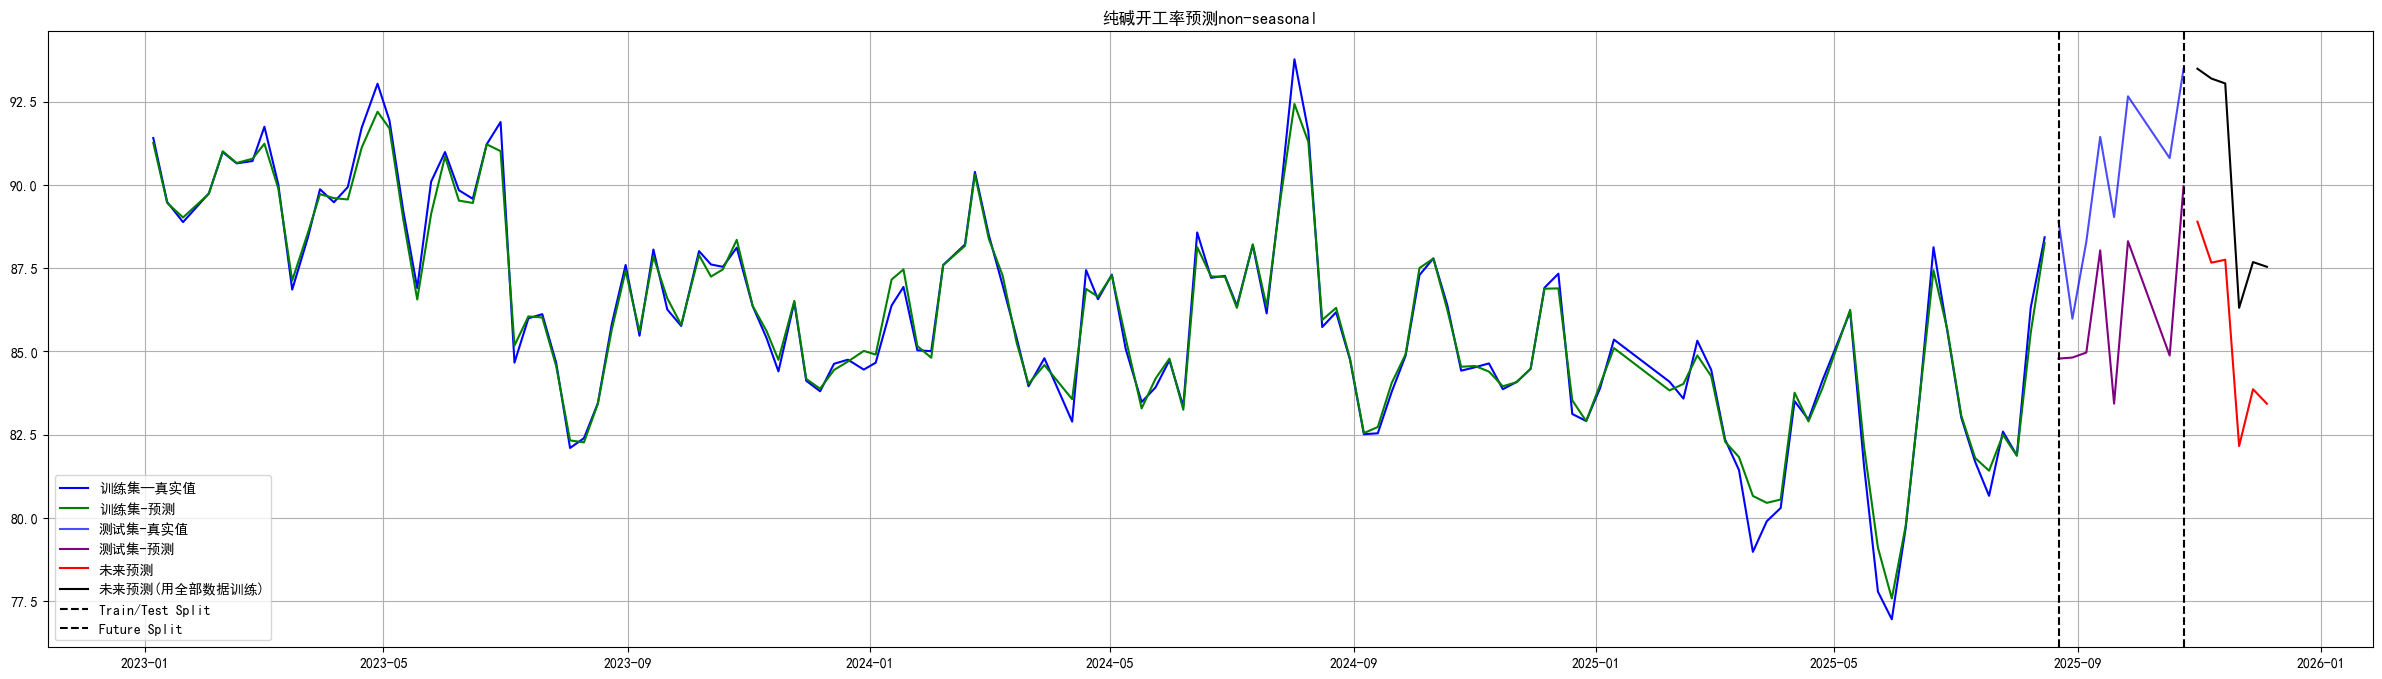

,Date,纯碱开工率（周度）noseasonal/F 0.1,纯碱开工率（周度）,纯碱行业利润/周频拟合残差/纯碱开工率（周度）noseasonal/F 0.1,纯碱行业利润/周频,纯碱企业库存8周环差,纯碱开工率（周度）Seasonal/F0.1(预测),纯碱行业利润/周频_提前5周,纯碱企业库存8周环差_提前8周,纯碱行业利润/周频拟合残差/纯碱开工率（周度）noseasonal/F 0.1_提前9周,...,纯碱企业库存8周环差_提前8周_逆序_分类_1,纯碱企业库存8周环差_提前8周_逆序_分类_2,纯碱企业库存8周环差_提前8周_逆序_分类_3,纯碱企业库存8周环差_提前8周_逆序_分类_4,纯碱企业库存8周环差_提前8周_逆序_分类_5,纯碱企业库存8周环差_提前8周_逆序_分类_6,纯碱企业库存8周环差_提前8周_逆序_分类_7,纯碱开工率（周度）noseasonal_平滑,预测值,预测值_全量
205,2025-10-31,NaN,NaN,NaN,-256.716,16829.92,-8.9844,-140.1380,-4.13,-212.8192,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,92.14455,88.892487,93.486397
206,2025-11-07,NaN,NaN,NaN,-256.716,16829.92,-8.9839,-136.4120,-10.81,-280.3547,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,93.48640,87.662033,93.192551
207,2025-11-14,NaN,NaN,NaN,-256.716,16829.92,-8.8713,-122.1893,-10.90,-324.0905,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN,87.750793,93.044556
208,2025-11-21,NaN,NaN,NaN,-256.716,16829.92,-8.3561,-171.0160,-14.43,-276.0092,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN,82.156136,86.306473
209,2025-11-28,NaN,NaN,NaN,-256.716,16829.92,-7.7247,-212.9893,-17.48,-364.7842,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN,83.861259,87.680298
210,2025-12-05,NaN,NaN,NaN,-256.716,16829.92,-7.7247,-256.7160,-20.53,-350.5615,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,NaN,83.426361,87.538551


In [11]:


plt.figure(figsize=(30, 8))
# 绘制主要数据
future_data = plot_predictions(y_test, future_data, col=True, label=True)
plt.plot(train_data['Date'], y_train, label='训练集—真实值', color='blue')
plt.plot(train_data['Date'], y_train_pred_dmatrix, label='训练集-预测', color='green')
plt.plot(test_data['Date'], y_test, label='测试集-真实值', color='blue', alpha=0.7)
plt.plot(test_data['Date'], y_test_pred_dmatrix, label='测试集-预测', color='purple')
plt.plot(future_data['Date'], future_data['预测值'], label='未来预测', color='red')
plt.plot(future_data['Date'], future_data['预测值_全量'], label='未来预测(用全部数据训练)', color='black')
# 添加分割线
plt.axvline(x=test_data['Date'].iloc[0], color='black', linestyle='--', label='Train/Test Split')
plt.axvline(x=last_day, color='black', linestyle='--', label='Future Split')
# 设置标题和图例
plt.title('纯碱开工率预测non-seasonal')
plt.legend()
plt.grid(True)
plt.show()
future_data

---

In [12]:
sheet_daily_trend = sheet_daily[['Date','纯碱开工率（周度）noseasonal/F 0.1','纯碱开工率（周度）Seasonal/F0.1(预测)','纯碱开工率（周度）']].copy()
# 将future_data中的预测值_全量与sheet_daily_trend合并
sheet_daily_trend = pd.merge(
    sheet_daily_trend,
    future_data[['Date', '预测值_全量']],
    on='Date',
    how='left'
)
# 将预测值_全量列重命名为纯碱开工率（周度）noseasonal/F 0.1_预测
sheet_daily_trend = sheet_daily_trend.rename(columns={'预测值_全量': '纯碱开工率（周度）noseasonal/F 0.1_预测'})

# 将test_data中的预测值与sheet_daily_trend合并
sheet_daily_trend = pd.merge(
    sheet_daily_trend,
    test_data[['Date', '预测值']].rename(columns={'预测值': '纯碱开工率（周度）noseasonal/F 0.1_测试集预测'}),
    on='Date', 
    how='left'
)

sheet_daily_trend['纯碱开工率_预测'] = sheet_daily_trend['纯碱开工率（周度）noseasonal/F 0.1_预测'] + sheet_daily_trend['纯碱开工率（周度）Seasonal/F0.1(预测)']
sheet_daily_trend['纯碱开工率_回测'] = sheet_daily_trend['纯碱开工率（周度）noseasonal/F 0.1_测试集预测'] + sheet_daily_trend['纯碱开工率（周度）Seasonal/F0.1(预测)']
sheet_daily_trend.tail(6)


,Date,纯碱开工率（周度）noseasonal/F 0.1,纯碱开工率（周度）Seasonal/F0.1(预测),纯碱开工率（周度）,纯碱开工率（周度）noseasonal/F 0.1_预测,纯碱开工率（周度）noseasonal/F 0.1_测试集预测,纯碱开工率_预测,纯碱开工率_回测
139,2025-10-31,NaN,-8.9844,NaN,93.486397,NaN,84.501997,NaN
140,2025-11-07,NaN,-8.9839,NaN,93.192551,NaN,84.208651,NaN
141,2025-11-14,NaN,-8.8713,NaN,93.044556,NaN,84.173256,NaN
142,2025-11-21,NaN,-8.3561,NaN,86.306473,NaN,77.950373,NaN
143,2025-11-28,NaN,-7.7247,NaN,87.680298,NaN,79.955598,NaN
144,2025-12-05,NaN,-7.7247,NaN,87.538551,NaN,79.813851,NaN


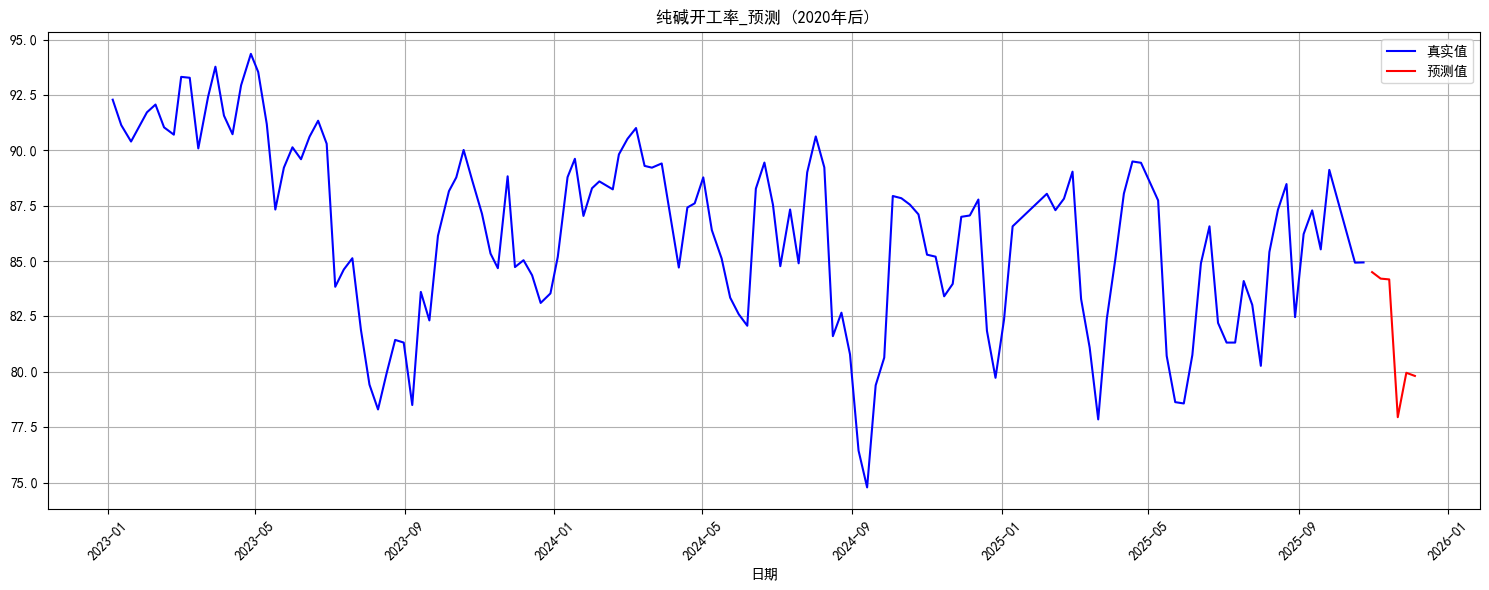

In [13]:
# 筛选2022年之后的数据
plot_data = sheet_daily_trend[sheet_daily_trend['Date'].dt.year >= 2022].copy()


plt.figure(figsize=(15, 6))
plt.plot(plot_data['Date'], plot_data['纯碱开工率（周度）'], label='真实值', color='blue')
plt.plot(plot_data['Date'], plot_data['纯碱开工率_预测'], label='预测值', color='red')

plt.title('纯碱开工率_预测 (2020年后)')
plt.xlabel('日期')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [14]:
merged_df_daily_together = sheet_daily_trend[['Date','纯碱开工率（周度）','纯碱开工率_预测']].copy()
merged_df_daily_together = merged_df_daily_together.sort_values('Date', ascending=False)
merged_df_daily_together['Date'] = merged_df_daily_together['Date'].dt.strftime('%Y/%m/%d')
merged_df_daily_together.to_excel('eta/纯碱开工率_合并数据.xlsx', index=False,float_format='%.1f')

merged_df_daily_together.head()

,Date,纯碱开工率（周度）,纯碱开工率_预测
144,2025/12/05,NaN,79.813851
143,2025/11/28,NaN,79.955598
142,2025/11/21,NaN,77.950373
141,2025/11/14,NaN,84.173256
140,2025/11/07,NaN,84.208651


In [15]:
merged_df_monthly_together = sheet_daily_trend[['Date','纯碱开工率（周度）','纯碱开工率_预测','纯碱开工率_回测']].copy()
# 合并预测值和回测值到一个列
merged_df_monthly_together['预测值'] = merged_df_monthly_together['纯碱开工率_预测'].combine_first(merged_df_monthly_together['纯碱开工率_回测'])
# 删除原来的列
merged_df_monthly_together.drop(['纯碱开工率_预测', '纯碱开工率_回测'], axis=1, inplace=True)
merged_df_monthly_together.set_index('Date', inplace=True)
merged_df_monthly_together = merged_df_monthly_together.resample('ME').mean()
merged_df_monthly_together.reset_index(inplace=True)
merged_df_monthly_together =merged_df_monthly_together.sort_values('Date', ascending=False)
merged_df_monthly_together['Date'] = merged_df_monthly_together['Date'].dt.strftime('%Y/%m/%d')
# 保存成excel
merged_df_monthly_together.to_excel('eta/纯碱开工率_月度数据.xlsx', index=False, float_format='%.1f')
merged_df_monthly_together.head()

,Date,纯碱开工率（周度）,预测值
35,2025/12/31,NaN,79.813851
34,2025/11/30,NaN,81.571969
33,2025/10/31,84.935,81.639027
32,2025/09/30,87.040,82.866901
31,2025/08/31,84.790,82.828272


---

In [16]:
################################# 训练预测数据 excel格式输出  #################################
'''
1. 日度数据 （真实值 和 预测值）
2. 月度数据 （真实值、训练值、预测值）
'''

############ 日度 数据 ############
# 创建日度数据框
historical_actual_daily = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})
# 只保留2023年之后的数据
historical_actual_daily = historical_actual_daily[historical_actual_daily['Date'].dt.year >= 2023]
# 创建预测数据框
future_pred_daily = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值_全量']
})


merged_df_daily = pd.merge(historical_actual_daily, future_pred_daily, on='Date', how='outer')
merged_df_daily = merged_df_daily.sort_values('Date', ascending=False)
merged_df_daily['Date'] = merged_df_daily['Date'].dt.strftime('%Y/%m/%d')
merged_df_daily.to_excel('eta/纯碱开工率Non-Seasonal_合并数据.xlsx', index=False,float_format='%.1f')

merged_df_daily

,Date,真实值,预测值
144,2025/12/05,NaN,87.538551
143,2025/11/28,NaN,87.680298
142,2025/11/21,NaN,86.306473
141,2025/11/14,NaN,93.044556
140,2025/11/07,NaN,93.192551
...,...,...,...
4,2023/02/09,90.9826,NaN
3,2023/02/02,89.7430,NaN
2,2023/01/20,88.8807,NaN
1,2023/01/12,89.4831,NaN


In [17]:
############ 月度 数据 ############
# 历史真实值
historical_actual_monthly = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})
# 真实数据 只保留2023年之后的
historical_actual_monthly = historical_actual_monthly[historical_actual_monthly['Date'].dt.year >= 2023]
# 2024年及以后训练集预测值
train_pred_2024 = pd.DataFrame({
    'Date': train_data[train_data['Date'].dt.year >= 2024]['Date'],
    '预测值':y_train_pred_dmatrix[train_data['Date'].dt.year >= 2024]
})
# 2024年及以后c测试集集预测值
test_pred_2024 = test_data[['Date', '预测值']].copy()
# 未来预测值 
future_pred_2024 = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值_全量']
})
# 合并 训练集预测+测试集预测+未来预测
future_pred_monthly = pd.concat([
    train_pred_2024, 
    test_pred_2024, 
    future_pred_2024
    ], axis=0).sort_values('Date')

# 合并历史真实值和预测值
merged_df_monthly = pd.merge(historical_actual_monthly, future_pred_monthly, on='Date', how='outer')
merged_df_monthly.set_index('Date', inplace=True)
merged_df_monthly = merged_df_monthly.resample('ME').mean()
merged_df_monthly.reset_index(inplace=True)
merged_df_monthly =merged_df_monthly.sort_values('Date', ascending=False)
merged_df_monthly['Date'] = merged_df_monthly['Date'].dt.strftime('%Y/%m/%d')
# 保存成excel
merged_df_monthly.to_excel('eta/纯碱开工率Non-Seasonal_月度数据.xlsx', index=False, float_format='%.1f')
merged_df_monthly.head()

,Date,真实值,预测值
35,2025/12/31,NaN,87.538551
34,2025/11/30,NaN,90.055969
33,2025/10/31,92.14455,89.440193
32,2025/09/30,90.35580,86.182701
31,2025/08/31,86.29974,85.054710


---

In [18]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.玻璃纯碱_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "纯碱开工率Non-Seasonal"

# 调用函数更新数据
success = update_excel_data(merged_df_daily, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [19]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.玻璃纯碱_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "纯碱开工率"

# 调用函数更新数据
success = update_excel_data(merged_df_daily_together, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [20]:
from Lcel import update_excel_data
file_path = "eta/1.玻璃纯碱_数据上传.xlsx"
sheet_name = "详情页"
identifier = "纯碱开工率Non-Seasonal"
# 调用函数更新数据
success = update_excel_data(merged_df_monthly, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")


数据过滤完成: 保留 24 条数据（2024/01/31 之后），按时间倒序排列
已完成：插入/更新数据，并重新计算'方向/偏差率' (protected_date = 2025/10/31, cutoff_date = 2024/01/31)
数据已成功更新到Excel文件


In [21]:
from Lcel import update_excel_data
file_path = "eta/1.玻璃纯碱_数据上传.xlsx"
sheet_name = "详情页"
identifier = "纯碱开工率"
# 调用函数更新数据
success = update_excel_data(merged_df_monthly_together, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

数据过滤完成: 保留 24 条数据（2024/01/31 之后），按时间倒序排列
已完成：插入/更新数据，并重新计算'方向/偏差率' (protected_date = 2025/10/31, cutoff_date = 2024/01/31)
数据已成功更新到Excel文件
